# Time series validation of PCR-GLOBWB nc-ouptput

This notebooks contains a couple of functions facilitating the extraction of time series from GRDC-files and from nc-files containing PCR-GLOBWB output.

The time series can then be plotted individually and futher analysed in some post-processing steps.

The notebook contains additioanl functions to determine monthly averages over the entire time series as well as functions to validate simulations against observations.

In this notebook, the required packages are first loaded. Then, the functions are defined. Third, data is extracted and plotted in cases. Fourth, the daily values are validated. Last, monthly averages are computed and validated as well.

### Load packages and print system information

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform))

this notebook was created using Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)] on a win32


### Define functions

In [3]:
def get_grdc_station_properties(fo):
    """
    gets GRDC station properties from txt-file.
    creates and returns header from those properties as well as dictionary.
    
    input:
    -------
    fo {string} = path to txt-file
    
    output:
    -------
    plot_title {string} = header
    props {dict} = dictionary with GRDC station name, latitude, and longitude
    """
    
    # open file
    fp = open(fo)
    
    # go through lines in file
    for i, line in enumerate(fp):
        
        # station name normally in line 11 of GRDC file
        if i == 10:
            station_grdc = line
            # check whether line contains station information
            if 'Station'not in station_grdc.split(":")[0]:
                os.sys.exit('Station name should be in line 11 but not found - please check if input txt-file is original GRDC format!')
            # split and strip string
            station_grdc = station_grdc.split(":")[-1].strip()  
        
        # latitude normally in line 13 of GRDC file
        if i == 12:
            lat_grdc = line
            if 'Latitude'not in lat_grdc.split(":")[0]:
                os.sys.exit('Latitude should be in line 13 but not found - please check if input txt-file is original GRDC format!')
            lat_grdc = lat_grdc.split(":")[-1].strip()
            
        # longitude normally in line 14 of GRDC file
        elif i == 13:
            lon_grdc = line
            if 'Longitude'not in lon_grdc.split(":")[0]:
                os.sys.exit('Latitude should be in line 13 but not found - please check if input txt-file is original GRDC format!')
            lon_grdc = lon_grdc.split(":")[-1].strip()
            
        # break loop to save time    
        elif i > 13:
            break
            
    # close file        
    fp.close()
    
    # write station name, latitude, and longitude to dic
    props = dict(station=str(station_grdc), latitude=float(lat_grdc), longitude=float(lon_grdc))
    
    # create simple title for plots
    plot_title = 'station ' + str(station_grdc) + ' at latitude/longitude ' + str(lat_grdc) + '/' + str(lon_grdc)
    
    return plot_title, props

In [4]:
def get_grdc_station_values(fo, val_name, remove_mv=True, mv_val=-999, print_head=False, plot=False, plot_title=None):
    """
    reads (discharge) values of GRDC station from txt-file.
    creates a pandas dataframe with a user-specified column header for values instead of default ' Values' header name.
    also possible to remove possible missing values in the timeseries and plot the resulting series.
    
    input:
    -------
    fo {string} = path to txt-file
    val_name {string} = user-specified column header name
    remove_mv {bool} = True/False whether missing values should be removed (default: True)
    mv_val {int} = integer value corresponding to missing value in timeseries (default: -999)
    print_head {bool} = True/False whether df.head() is printed (default: False)
    plot {bool} = True/False whether dataframe should be plotted (default: False)
    plot_title {str} = title of dataframe plot (default: None)
    
    output:
    -------
    df {dataframe} = dataframe containing GRDC values per time step
    """
    
    #TODO: the number of rows to be skipped seem to change between files
    # appraoch: make it generic by scanning until lines do not start with # anymore
    df = pd.read_csv(fo, skiprows=40, sep=';')
        
    df[val_name] = df[' Original'].copy()
    del df[' Original']
    
    df['date'] = pd.to_datetime(df['YYYY-MM-DD'])
    df.set_index(df['date'], inplace=True)
    
    if remove_mv == True:
        df[val_name].replace(mv_val, np.nan, inplace=True)
    
    if print_head == True:
        print(df.head())
        
    if plot == True:
        df[val_name].plot(title=plot_title, legend=True)
    
    return df

In [5]:
def find_indices_from_coords(fo, lon, lat):
    """
    Read in georeferenced 2D file (e.g. tiff or nc-file) and 
    get row and column indices corresponding to given longitude and latitude information.
    
    input:
    ------
    fo {str} = georeferenced 2D file
    lon {float} = longitude of point
    lat {float} = latitude of point
    
    output:
    -------
    row {float} = row corresponding to longitude
    col {float} = column corresponding to latitude
    """
    
    # open file
    ds = rio.open(fo)
    
    # get indices
    row, col = ds.index(lon, lat)
    
    # close file
    ds.close()
    
    return row, col

In [6]:
def read_nc_file_at_indices(fo, idx_row, idx_col, var_name='discharge', plot=False, plot_var_name=None, plot_title=None):
    """
    reading a nc-file and retrieving variable values at given column and row indices.
    default setting is that discharge is extracted at this point.
    resulting timeseries is stored as pandas timeframe and can be plotted with user-specified variable name and title.
    
    input:
    ------
    fo {str} = georeferenced 2D nc-file
    idx_row {float} = row index
    idx_col {float} = column index
    var_name {str} = name of variable to be retrieved in nc-file (default: 'discharge')
    plot {bool} = True/False whether timeseries is plooted
    plot_var_name {str} = user-specified alternative name of variable in plot (default: None)
    plot_tile {str} = user-specified plot title (default: None)
    
    output:
    -------
    df {dataframe} = dataframe containing variable values per time step, i.e. alrady datetime as indices
    """
    
    # open file
    ds = xr.open_dataset(fo)
    
    # read variable values at indices as xarray DataArray
    dsq = ds[var_name].isel(lat=row, lon=col)
    
    # change variable names if specified
    if plot_var_name != None:
        var_name = plot_var_name
    
    # convert DataArray to pandas dataframe
    df = pd.DataFrame(data=dsq.to_pandas(), 
                  columns=[var_name])
    
    # plot if specified
    if plot == True:
        df.plot(title=plot_title)
    
    # close file
    ds.close()
    
    return df

In [7]:
def calc_montly_avg(df_in, var_name=None):
    """
    calculates the monthly averages of a time series.
    
    input:
    ------
    df_in {dataframe} = dataframe containing daily values
    var_name {str} = column header in df_in containing observed values. this is handy
                            if dataframe contains more than one column with values. if 'None',
                            it is assumed that only one column with values exists (default: None).
                            
    output:
    -------
    df_out {dataframe} = dataframe containing one column only with monthly average values.
    """
    
    # if variable name is not None, then pick values from specified column
    if var_name != None:
        df = df_in[var_name]
    # else, just use the dataframe as is
    else:
        df = df_in
    
    # group values by month and then calculate mean
    df_out = df.groupby(df.index.month).mean()
    
    return df_out

In [8]:
def plot_var_at_timestep(fo, var_name, time, savefig=False, outdir=None):
    """
    plots variable at a given timestep from 2D netcdf file.
    
    input:
    ------
    fo {str} = georeferenced 2D nc-file
    var_name {str} = name of variable to be retrieved in nc-file
    time {str} = time at which variable is plotted
    savefig {bool} = True/False whether plot is saved to png at 300 dpi (default: False)
    outdir {str} = output directory where plot is stored (default: None)
    
    output:
    -------
    None
    """
    
    if savefig == True and outdir == None:
        os.sys.exit('No output directory for saving figure specified.')
    
    ds = xr.open_dataset(fo)
    
    plt.figure()
    qplot = ds[var_name].sel(time=time).plot()
        
    if savefig:
        f_name = var_name + '_' + time + '.png'
        plt.savefig(os.path.join(outdir, f_name), dpi=300)

In [9]:
def validate_results(df_obs, df_sim, var_name_obs=None, var_name_sim=None, plot=False):
    """
    validates observed and simulated values in a timeseries. 
    computes KGE, NSE, RMSE, and R^2.
    concatenates the two dataframes and drops all NaNs to achieve dataframe with common
    time period.
    
    input:
    ------
    df_obs {dataframe} = dataframe containing observed values
    df_sim {dataframe} = dataframe containing simulated values
    var_name_obs {str} = column header in df_obs containing observed values. this is handy
                            if dataframe contains more than one column with values. if 'None',
                            it is assumed that only one column with values exists (default: None).
    var_name_sim {str} = column header in df_sim containing simulated values. this is handy
                            if dataframe contains more than one column with values. if 'None',
                            it is assumed that only one column with values exists (default: None).
    plot {bool} = True/False whether data of common time period is plotted (default: False)
    
    output:
    -------
    evaluation {dict} = dictionary containing computed values per objective function    
    
    """
    
    # if variable name is not None, then pick values from specified column
    if var_name_obs != None:
        df_obs = df_obs[var_name_obs]
    # else, just use the dataframe as is
    else:
        df_obs = df_obs
        
    # idem  
    if var_name_sim != None:
        df_sim = df_sim[var_name_sim]
    else:
        df_sim = df_sim
    
    # concatenate both dataframes
    both = pd.concat([df_obs, df_sim], axis=1)
    # drop all entries where any of the dataframes contains NaNs
    # this yields a dataframe containing values only for common time period
    both = both.dropna()
    
    # raise error if there is no common time period
    if both.empty:
        os.sys.exit('no common time period of observed and simulated values found in dataframes!')
    
    # plot if specified
    if plot == True:
        both.plot()
    
    # convert to np-arrays
    obs = both[both.columns[0]].to_numpy()
    sim = both[both.columns[1]].to_numpy()
    
    # apply objective functions
    kge = sp.objectivefunctions.kge(obs, sim)
    nse = sp.objectivefunctions.nashsutcliffe(obs, sim)
    rmse = sp.objectivefunctions.rmse(obs, sim)
    r2 = sp.objectivefunctions.rsquared(obs, sim)
    
    # fill dict
    evaluation = {'KGE': kge,
                  'NSE': nse,
                  'RMSE': rmse,
                  'R2': r2}
    
    return evaluation

### specify paths to input files

In [10]:
# nc file of discharge in Amazon basin
ncf = r'example_data/DUMMY_discharge_dailyTot_output.nc'

In [11]:
# text file containing meta-data and observed values at specific GRDC station
grdc_fo = 'example_data/3629000_Obidos.day'

In [12]:
# specifying variable names to be used in column headers and plotting
new_var_name_sim = 'Q$sim$ PCR-GLOBWB [m3/s]'
new_var_name_obs = 'Q$obs$ GRDC [m3/s]'

### get information about GRDC station and its location

In [13]:
# get a simple plot_title and properties of GRDC station
plot_title, props = get_grdc_station_properties(grdc_fo)
print(props)

{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


In [14]:
# based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = find_indices_from_coords(ncf, props['longitude'], props['latitude'])
print(row, col)

17 50


<Figure size 432x288 with 0 Axes>

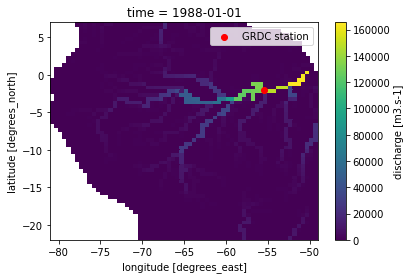

In [15]:
# for visualization purposed, it is also possible to plot variable from nc-file for given data
# and also location of GRDC station on the map
plt.figure()
plot_var_at_timestep(ncf, var_name='discharge', time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station')
plt.legend()

### Reading values files and visualzing them

In [16]:
# reading values at row/col indices for all time steps
q_sim_obidos = read_nc_file_at_indices(ncf, row, col, plot_var_name=new_var_name_sim)

In [17]:
# reading values from GRDC station text file and providing a variable name
df_GRDC = get_grdc_station_values(grdc_fo, val_name=new_var_name_obs)

<Figure size 432x288 with 0 Axes>

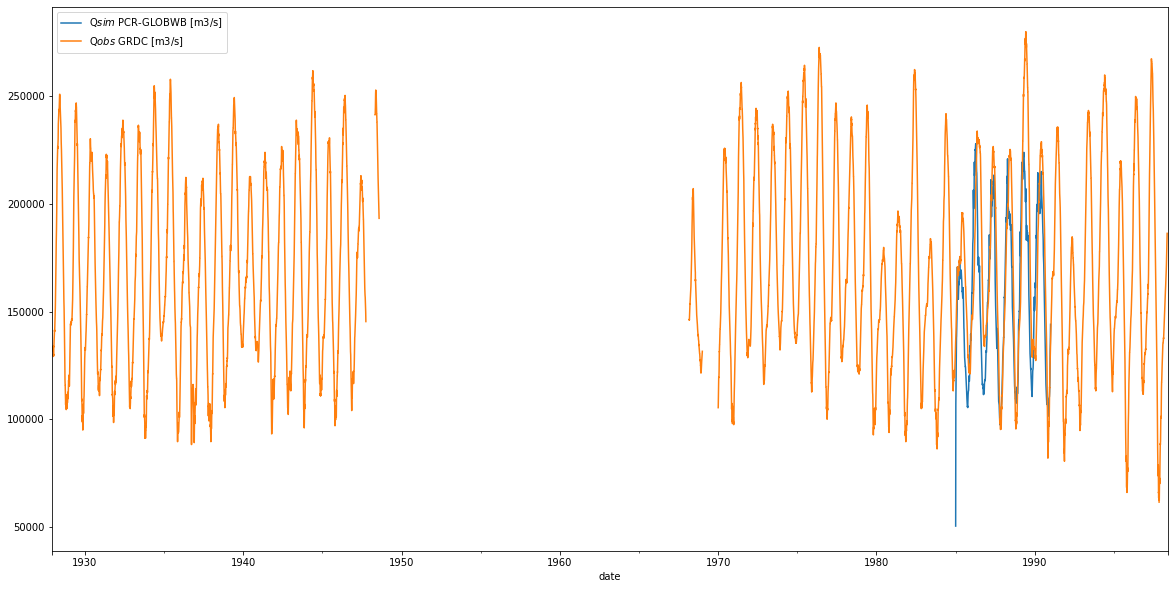

In [18]:
# plotting both simulated and observed discharge at GRDC station
plt.figure()
q_sim_obidos.plot()
df_GRDC[new_var_name_obs].plot(figsize=(20,10))
plt.legend()

### Validation of daily values

{'KGE': 0.7121953016339049,
 'NSE': 0.49627672211755103,
 'RMSE': 30911.840814351533,
 'R2': 0.5995766148762273}

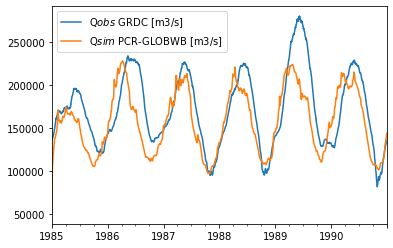

In [19]:
# validating simulations with observations for common time period
eval_dic = validate_results(df_GRDC, q_sim_obidos, new_var_name_obs, new_var_name_sim, plot=True)
eval_dic

### Compute monthly averages and validate those

In [20]:
# get monthly averages first
df_GRDC_monthly = calc_montly_avg(df_GRDC, var_name=new_var_name_obs)
q_sim_obidos_montly = calc_montly_avg(q_sim_obidos, var_name=new_var_name_sim)

{'KGE': 0.6883061166429888,
 'NSE': 0.3373191513507068,
 'RMSE': 27102.25070278959,
 'R2': 0.6256308387958736}

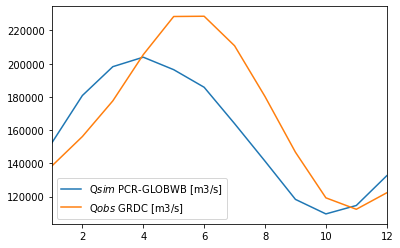

In [21]:
# apply validation function again
eval_dic = validate_results(q_sim_obidos_montly, df_GRDC_monthly, plot=True)
eval_dic